In [8]:
import os
import yaml
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image as Image
os.chdir("/home/nisla/copernicus")


In [9]:
with open("config/default.yaml", "r") as f:
    cfg = yaml.safe_load(f)

root = Path(cfg["data"]["root"])
processed_dir = Path(cfg["data"]["processed"])
labels_dir = Path(cfg["data"]["labels"])


In [10]:
print("Archivos en processed:", len(os.listdir(processed_dir)))
print("Archivos en labels:", len(os.listdir(labels_dir)))

Archivos en processed: 91820
Archivos en labels: 91820


Shape: (512, 512, 12)


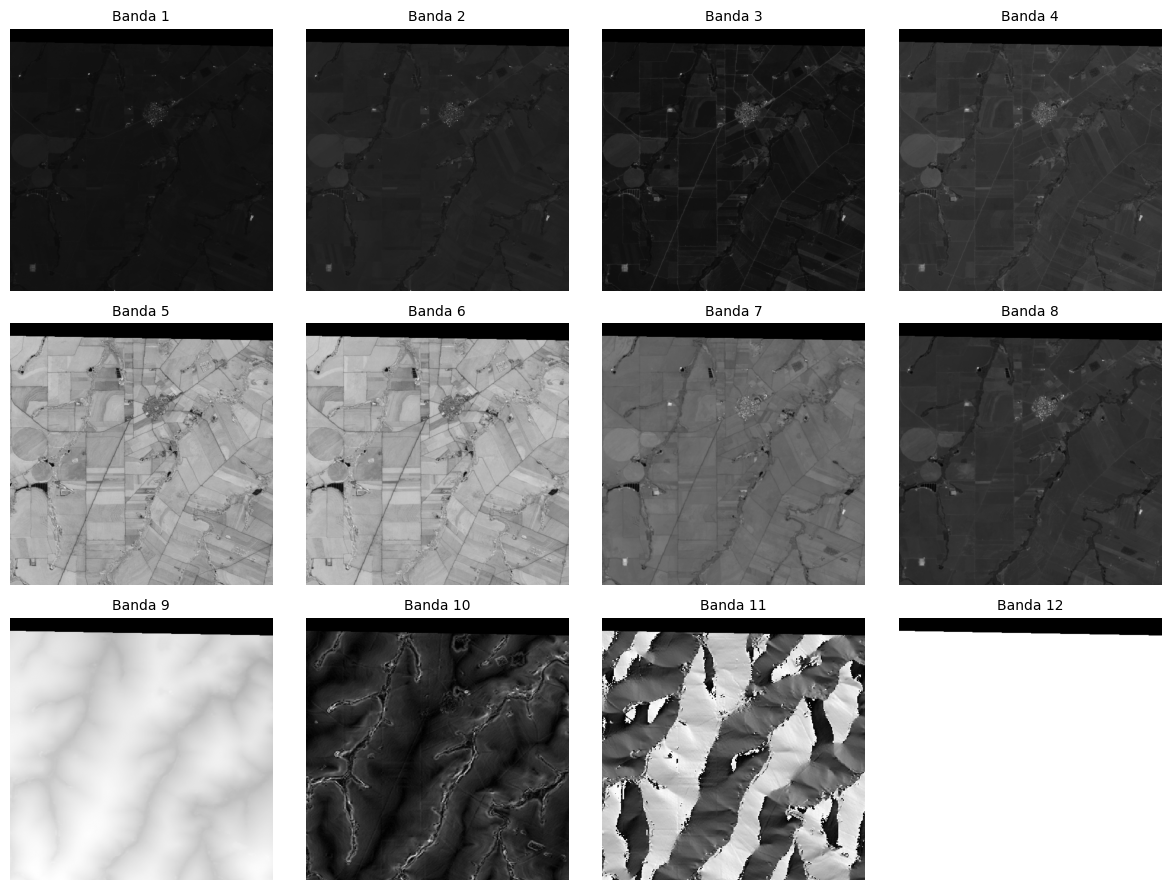

In [11]:
data = np.load(processed_dir / "patch_133656.npz")

X = data["X"]  # (512, 512, 12)

print("Shape:", X.shape)

# === Plot de las 12 bandas ===
fig, axes = plt.subplots(3, 4, figsize=(12, 9))
axes = axes.flatten()

for i in range(12):
    ax = axes[i]
    img = X[:, :, i]
    ax.imshow(img, cmap="gray")
    ax.set_title(f"Banda {i+1}", fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()

Shape: (512, 512)
Valores únicos (clases): [ 0  1  2  3  4 11]


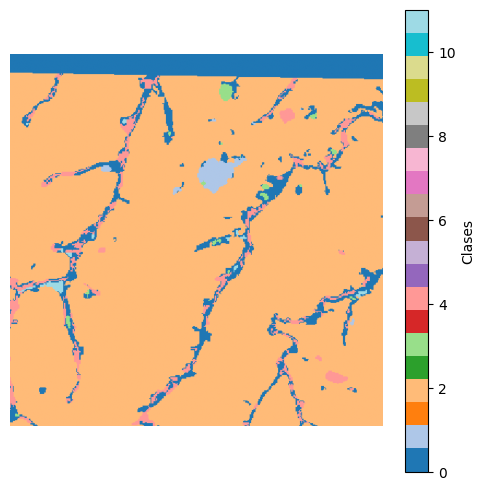

In [12]:
label_path = labels_dir / "patch_133656.png"

# Cargar el label
label = np.array(Image.open(label_path))

print("Shape:", label.shape)
print("Valores únicos (clases):", np.unique(label))

# Plot
plt.figure(figsize=(6, 6))
plt.imshow(label, cmap="tab20")  # paleta de colores categórica
plt.colorbar(label="Clases")
plt.axis("off")
plt.show()

In [13]:
label

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2]], shape=(512, 512), dtype=uint8)

In [17]:
os.listdir(root)

['npz',
 'patch_index.csv',
 'patch_counter.txt',
 'patch_index.xlsx',
 'patch_errors.log',
 'labels']

In [20]:
import numpy as np
import pandas as pd
from pathlib import Path

# Estratificación multietiqueta (preserva prevalencia por clase)
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

def stratified_train_val_test_from_counts(
    df_counts: pd.DataFrame,
    patch_col: str = "patch_id",
    class_cols: list[str] | None = None,
    test_size: float = 0.15,
    val_size: float = 0.15,
    random_state: int = 42,
):
    """
    Divide parches en train/val/test preservando la prevalencia por clase (multilabel),
    a partir de una tabla con conteos de píxeles por clase.

    - df_counts: DataFrame con 'patch_id' y columnas class_* con conteos.
    - class_cols: lista de columnas de clases. Si None, se infiere como las que comienzan con 'class_'.
    - test_size, val_size: fracciones del total.
    Retorna:
      splits (dict): {'train': idx, 'val': idx, 'test': idx} con índices de df_counts
      summary (DataFrame): resumen por split (suma y % por clase)
    """
    if class_cols is None:
        class_cols = [c for c in df_counts.columns if c.startswith("class_")]
    assert 0 < test_size < 1 and 0 < val_size < 1 and test_size + val_size < 1

    # Y_bin: presencia de clase por parche (1 si hay píxeles de esa clase)
    Y_counts = df_counts[class_cols].values.astype(np.int64)
    Y_bin = (Y_counts > 0).astype(int)

    idx_all = np.arange(len(df_counts))

    # 1) split train_val vs test
    msss1 = MultilabelStratifiedShuffleSplit(
        n_splits=1, test_size=test_size, random_state=random_state
    )
    trainval_idx, test_idx = next(msss1.split(idx_all.reshape(-1, 1), Y_bin))

    # 2) split train vs val dentro de trainval
    val_rel = val_size / (1.0 - test_size)
    msss2 = MultilabelStratifiedShuffleSplit(
        n_splits=1, test_size=val_rel, random_state=random_state
    )
    train_idx, val_idx = next(msss2.split(trainval_idx.reshape(-1, 1), Y_bin[trainval_idx]))

    # Mapear a índices absolutos
    train_idx = trainval_idx[train_idx]
    val_idx   = trainval_idx[val_idx]

    splits = {"train": train_idx, "val": val_idx, "test": test_idx}

    # ===== Resumen de distribución por split =====
    def _sum_counts(rows):
        return df_counts.loc[rows, class_cols].sum(axis=0)

    totals = {
        "train": _sum_counts(train_idx),
        "val":   _sum_counts(val_idx),
        "test":  _sum_counts(test_idx),
        "all":   df_counts[class_cols].sum(axis=0)
    }
    summary = pd.DataFrame(totals).T  # filas = split, cols = clases
    # Porcentajes relativos por clase respecto al total "all"
    pct = (summary.div(summary.loc["all"], axis=1) * 100).fillna(0.0)
    pct.index = [f"{i}_pct" if i != "all" else i for i in pct.index]

    summary_out = pd.concat([summary, pct.loc[["train_pct", "val_pct", "test_pct"]]], axis=0)

    # Prints útiles
    print("=== Tamaños (parches) ===")
    print(f"train: {len(train_idx)} | val: {len(val_idx)} | test: {len(test_idx)} | total: {len(df_counts)}")

    # Desviación promedio de % por clase respecto al total entre splits
    def _mean_abs_dev(row_pct):
        # diferencia absoluta promedio contra % ideal = (split_size/total)*100, pero aquí comparamos entre splits
        return np.mean(np.abs(row_pct.values - row_pct.values.mean()))

    mad_train = _mean_abs_dev(pct.loc["train_pct"])
    mad_val   = _mean_abs_dev(pct.loc["val_pct"])
    mad_test  = _mean_abs_dev(pct.loc["test_pct"])
    print(f"Desviación media absoluta de % por clase (entre splits):")
    print(f"  train: {mad_train:.3f} pp | val: {mad_val:.3f} pp | test: {mad_test:.3f} pp")

    return splits, summary_out



In [24]:

df_counts = pd.read_csv(root / "patch_index.csv")  # Debe contener 'patch_id' y columnas class_*
splits, summary = stratified_train_val_test_from_counts(
    df_counts,
    patch_col="patch_id",
    class_cols=[c for c in df_counts.columns if c.startswith("class_")],
    test_size=0.15,
    val_size=0.15,
    random_state=42,
)
print("\n=== Resumen por split (conteos y % por clase) ===")
print(summary.round(3).to_string())

# Si quieres DataFrames con los parches por split:
df_train = df_counts.iloc[splits["train"]].copy()
df_val   = df_counts.iloc[splits["val"]].copy()
df_test  = df_counts.iloc[splits["test"]].copy()

# Y verificar prevalencia por presencia (no solo conteo)
def presencia(row): return (row.values > 0).astype(int)
pres_all  = df_counts[[c for c in df_counts.columns if c.startswith("class_")]].apply(presencia, axis=1, result_type="expand").sum()
pres_train= df_train[[c for c in df_counts.columns if c.startswith("class_")]].apply(presencia, axis=1, result_type="expand").sum()
pres_val  = df_val[[c for c in df_counts.columns if c.startswith("class_")]].apply(presencia, axis=1, result_type="expand").sum()
pres_test = df_test[[c for c in df_counts.columns if c.startswith("class_")]].apply(presencia, axis=1, result_type="expand").sum()
print("\nPresencia de clases (# de parches que contienen la clase) por split:")
pres_df = pd.DataFrame({"all": pres_all, "train": pres_train, "val": pres_val, "test": pres_test}).T
print(pres_df.to_string())

=== Tamaños (parches) ===
train: 64292 | val: 13762 | test: 13766 | total: 91820
Desviación media absoluta de % por clase (entre splits):
  train: 1.465 pp | val: 1.453 pp | test: 0.705 pp

=== Resumen por split (conteos y % por clase) ===
                class_0      class_11      class_12      class_21      class_22      class_23      class_24      class_31      class_32      class_41      class_42      class_43      class_44    class_45      class_51      class_61      class_71      class_81      class_91      class_92      class_93     class_101     class_111    class_112
train      1.277912e+09  2.222666e+08  8.776312e+06  1.074977e+09  1.166736e+09  4.505232e+07  2.782747e+08  1.488656e+09  2.845023e+09  2.330299e+09  3.098719e+08  9.102137e+08  2.017312e+09  325179.000  1.204704e+09  5.972850e+08  2.362785e+07  2.519966e+08  3.031990e+07  1.419497e+08  4.023991e+07  8.204920e+07  5.046180e+08  1275936.000
val        2.761227e+08  4.617836e+07  1.586619e+06  2.314819e+08  2.53166

In [25]:
df_train

,patch_id,source_file,npz,label,x,y,h,w,ratio_fondo,class_0,...,class_51,class_61,class_71,class_81,class_91,class_92,class_93,class_101,class_111,class_112
0,patch_000454,Argent_2022_18FXH.tif,out/npz/patch_000454.npz,out/labels/patch_000454.png,7168,0,512,512,0.067844,17785,...,465,181643,0,0,0,0,0,0,0,0
1,patch_000455,Argent_2022_18FXH.tif,out/npz/patch_000455.npz,out/labels/patch_000455.png,7680,0,512,512,0.066639,17469,...,1884,202042,0,0,0,0,0,0,0,0
4,patch_000490,Argent_2022_18FXH.tif,out/npz/patch_000490.npz,out/labels/patch_000490.png,8192,1024,512,512,0.001087,285,...,147,199291,0,0,0,0,0,292,0,0
5,patch_000507,Argent_2022_18FXH.tif,out/npz/patch_000507.npz,out/labels/patch_000507.png,8192,1536,512,512,0.022476,5892,...,298,186580,0,0,0,0,0,0,13588,0
6,patch_000677,Argent_2022_18FXJ.tif,out/npz/patch_000677.npz,out/labels/patch_000677.png,8192,1024,512,512,0.054867,14383,...,77575,62141,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91809,patch_224823,Brasil_2023_25MBQ.tif,out/npz/patch_224823.npz,out/labels/patch_224823.png,0,3584,512,512,0.065807,17251,...,0,0,0,0,0,0,0,0,0,0
91811,patch_224833,Brasil_2023_25MBQ.tif,out/npz/patch_224833.npz,out/labels/patch_224833.png,0,4096,512,512,0.142471,37348,...,0,0,0,0,0,0,0,0,0,0
91812,patch_224834,Brasil_2023_25MBQ.tif,out/npz/patch_224834.npz,out/labels/patch_224834.png,512,4096,512,512,0.304214,79748,...,0,0,0,0,0,0,0,0,1779,0
91816,patch_224844,Brasil_2023_25MBQ.tif,out/npz/patch_224844.npz,out/labels/patch_224844.png,512,4608,512,512,0.394501,103416,...,0,0,0,0,0,0,0,0,19,0


In [ ]:
import os
from pathlib import Path

# === Asumimos que ya tienes los splits y df_counts del paso anterior ===
# splits, summary = stratified_train_val_test_from_counts(df_counts, ...)
# df_counts: DataFrame original con patch_id y clases
# splits: diccionario con índices de train, val, test

# === 1. Crear carpeta de salida ===
output_dir = root / "standard_train"
output_dir.mkdir(parents=True, exist_ok=True)

# === 2. Extraer subconjuntos ===
df_train = df_counts.iloc[splits["train"]].copy()
df_val   = df_counts.iloc[splits["val"]].copy()
df_test  = df_counts.iloc[splits["test"]].copy()

# === 3. Guardar cada uno en CSV ===
train_path = output_dir / "train.csv"
val_path   = output_dir / "val.csv"
test_path  = output_dir / "test.csv"

df_train.to_csv(train_path, index=False)
df_val.to_csv(val_path, index=False)
df_test.to_csv(test_path, index=False)

print(f"✅ Archivos guardados en: {output_dir}")
print(f"  - train.csv: {len(df_train)} filas")
print(f"  - val.csv:   {len(df_val)} filas")
print(f"  - test.csv:  {len(df_test)} filas")

summary.to_csv(output_dir / "summary_distribution.csv")
print(f"📊 Distribución de clases guardada en: {output_dir / 'summary_distribution.csv'}")

✅ Archivos guardados en: /data/nisla/copernicus2/out/standard_train
  - train.csv: 64292 filas
  - val.csv:   13762 filas
  - test.csv:  13766 filas
📊 Distribución de clases guardada en: /data/nisla/copernicus2/out/standard_train/summary_distribution.csv
